# Visualización y valoración de planes de radioterapia mediante Histogramas Dosis Volumen
----------

Tener un conocimiento de cómo se distribuye espacialmente la dosis es esencial para valorar un plan de radioterapia (ver el otro cuaderno de este proyecto `MamaDerDistDosis.ipyno` **Visualización de tratamientos de radioterpia**), pero la distribución espacial de la dosis en sí misma es insuficiente para valorar cuantitativamente si el plan cumple con los objetivos de la prescripción afectando de forma tolerable a los órganos de riesgo.

Esta valoración cuantitativa se realiza empleando los denominados Histogramas Dosis Volumen o **DVH** por sus siglas en inglés.

`scikit-rt` también dispone de herramientas para obtener DVHs pero requiere de más código de lo que se necesita con otros paquetes de software de radioterapia. Esta parte de la visualización la vamos a realizar con un módulo python denominado `dicompyler-core`

In [1]:
from dicompylercore import dicomparser, dvh, dvhcalc

# La libreria general DICOM
import pydicom as dcm
# Manejo de listas de archivos
from glob import glob
# Otras librerias para facilitar la visualización
from matplotlib import pyplot as plt

In [2]:
%cd ..

/Users/cesar/Documents/Development/GitHub/rtviewer


El trabajo con `dicompyler-core`comienza leyendo el conjunto de estructuras mediante un objeto denominado `DicomParser`

In [4]:
dicomssfile = 'patients/TestMamaDer001/20230116_095704/RTSTRUCT/CT/20230116_095704/RS.1.2.246.352.205.5566667512400723974.375329800850442140.dcm'

dp = dicomparser.DicomParser(dicomssfile)
strs = dp.GetStructures()

`DicomParser` también se puede utilizar para leer la información de las distribuciones de dosis.

Definimos una función que nos dé la dosis en función del nombre del plan

In [5]:
def rtdoseparser(planname):
    dosefiles = glob('patients/TestMamaDer001/20230116_095704/RTDOSE/CT/20230116_095704/*.dcm')
    for dosefile in dosefiles:
        dicomdosefile = dcm.read_file(dosefile)
        dicomplanfile = dcm.read_file('patients/TestMamaDer001/20230116_095704/RTPLAN/CT/20230116_095704/RP.' +
                                       dicomdosefile.ReferencedRTPlanSequence[0].ReferencedSOPInstanceUID +
                                       '.dcm')
        if dicomplanfile.RTPlanLabel == planname:
            return dicomparser.DicomParser(dosefile)

Los planificadores de radioterapia pueden estar preparados para exportar junto con la dosis la información del DVH. En nuestro caso no hemos exportado esta información. Si leemos la distribución de dosis de un plan concreto y buscamos la información sobre el DVH `dicompyler-core` nos devuelve un error diciendo que la secuencia del DVH no está presente

In [6]:
rtdoseplan = rtdoseparser('FraccStdF2')

In [7]:
dvh.DVH.from_dicom_dvh(rtdoseplan.ds, 14)

AttributeError: 'FileDataset' object has no attribute 'DVHSequence'

En este caso tenemos que calcular el DVH a partir de las estructuras y la dosis

Definimos una función que nos devuelva el nombre del archivo de dosis en función del plan

In [8]:
def rtdosefile(planname):
    dosefiles = glob('patients/TestMamaDer001/20230116_095704/RTDOSE/CT/20230116_095704/*.dcm')
    for dosefile in dosefiles:
        dicomdosefile = dcm.read_file(dosefile)
        dicomplanfile = dcm.read_file('patients/TestMamaDer001/20230116_095704/RTPLAN/CT/20230116_095704/RP.' +
                                       dicomdosefile.ReferencedRTPlanSequence[0].ReferencedSOPInstanceUID +
                                       '.dcm')
        if dicomplanfile.RTPlanLabel == planname:
            return dosefile

Para calcular un DVH de una estructura pasamos el archivo de estructura, el de dosis y el índice de la estructura

In [9]:
calcdvh = dvhcalc.get_dvh(dicomssfile, rtdosefile('MamaDerSIB'), 14)

Podemos representar el histograma

DVH(cumulative, 5149 bins: [0.0:51.49] Gy, volume: 35.03125 cm3, name: 'PTV boost dcho', rx_dose: 0 Gy)

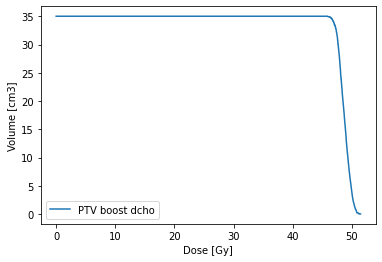

In [10]:
calcdvh.plot()

Buscamos los índices de las estructuras relevantes para nuestro problema: PTV mama dcha, PTV boost mama dcha, Pulmón dcho

In [11]:
for key in strs.keys():
    print(key, strs[key]['name'])

1 BODY
7 Corazon/pericard
8 CTV boost dcho
9 CTV mama dcha
10 Humero dcho
11 linea media
12 Medula
14 PTV boost dcho
15 PTV mama dcha
16 Pulmon Dcho
17 Pulmon Izqdo
18 Tiroides
19 CouchSurface
20 CouchInterior


Definimos la lista con los índices de las estructuras relevantes

In [25]:
ssrels = [14, 15, 16]

Definimos una función que representa los DVHs calculados para las estructuras relevantes y devuelve un diccionario que contiene los DVHs calculados utiilizando como parámetro el nombre de un plan concreto. La representación del plan la hacemos en unidades relativas del volumen de cada estructura (%) en función de la dosis absorbida (Gy).

In [38]:
def calcdvhrels(planname):
    cdvhs = {}
    for ssrel in ssrels:
        cdvhs[strs[ssrel]['name']] = dvhcalc.get_dvh(dicomssfile, rtdosefile(planname), ssrel) 
    [cdvh.relative_volume.plot() for cdvh in cdvhs.values()]
    return cdvhs

Podemos hacer una comparación de dos histogramas correspondientes a la dosis total impartida por dos esquemas diferentes de fraccionamiento.

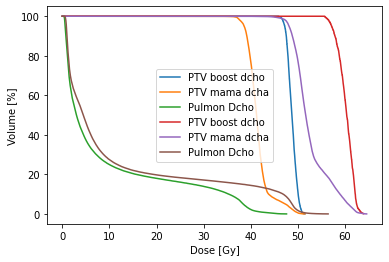

In [46]:
SIBcdvhs = calcdvhrels('MamaDerSIB')
FraccStdcdvhs = calcdvhrels('FraccStdF3')

Podemos obtener una descripción resumida del histograma

In [48]:
SIBcdvhs['PTV boost dcho'].describe()

Structure: PTV boost dcho
-----
DVH Type:  cumulative, abs dose: Gy, abs volume: cm3
Volume:    35.03 cm3
Max Dose:  51.49 Gy
Min Dose:  45.91 Gy
Mean Dose: 48.74 Gy
D100:      45.90 Gy
D98:       46.75 Gy
D95:       47.20 Gy
D2cc:      50.31 Gy


En general para valorar el plan necesitaremos detalles más concretos de lo que nos proporciona este resumen.

Los Oncólogos de Radioterapia pueden expresar sus requitos y restricciones sobre el plan tanto en valores relativos como en valores abosolutos tanto para el volumen del órgano como para la dosis absorbida.

A modo de ejemplo:
- V95 > 95 Se requiere que el volumen cubierto por el 95% de la dosis de prescripción sea mayor que el 95% del volumen del órgano
- V45Gy > 95 Se requiere que el volumen cubierto por la isodosis de 45 Gy sea mayor que el 95% del volumen del órgano
- V45 < 10cc Se requiere que el volumen cubierto por la isodosis de 45 Gy sea inferior a 10 centímetros cúbicos
- D95 > 95 Se requiere que la dosis que cubre el 95% del volumen sea superior al 95% de la dosis de prescripción
- D15 < 20Gy Se requiere que la dosis que cubre el 15% del volumen sea inferior a 20 Gy
- D0.5cc < 30Gy Se require que como máximo 0.5 cc reciban una dosis de 30 Gy.

Nótose que que la condición primera es diferente a la cuarta pese a su similitud.

`dicompyler-core` tiene métodos para acceder a los valores del histogramas en las distintas unidades y poder realizar estas comprobaciones.

Por ejemplo considermos el plan **MamaDerSIB**. Partimos de los histogramas calculados para sus órganos relevantes `SIBcdvhs`. Para obtener el valor V20Gy en el pulmón ipsilateral en unidades relativas 

In [88]:
SIBcdvhs['Pulmon Dcho'].relative_volume.statistic('V20Gy')

dvh.DVHValue(17.999365961908943, '%')

Es decir un 18% del volumen del pulmón recibe al menos 20 Gy.

Para obtener el mismo parámetros pero en unidades de volumen absoluto

In [89]:
SIBcdvhs['Pulmon Dcho'].statistic('V20Gy')

dvh.DVHValue(230.65625, 'cm3')

Para poder valorar volúmenes en unidades relativas de dosis primero es necesario definir la dosis de prescripción del volumen en unas unidades dadas. La opción por defecto en es grays aunque se pueden utilizar otras. Nosotros mantendremos la opción por defecto. 

Por ejemplo para en el esquema hipofraccionado la dosis al PTV de la mama completa es de 40.05 Gy.

In [94]:
SIBcdvhs['PTV mama dcha'].rx_dose = 40.05

Una vez definido ese parámetro podemos calcula el V95. Cuando no se dan unidades el paquete asume que estamos refiriendo unidades relativas en tanto por ciento, es decir, V95 es el volumen que recibe al menos el 95% de la dosis de prescripción

In [95]:
SIBcdvhs['PTV mama dcha'].relative_volume.statistic('V95')

dvh.DVHValue(97.12957677566664, '%')

O en términos de unidades absolutas de volumen

In [96]:
SIBcdvhs['PTV mama dcha'].statistic('V95')

dvh.DVHValue(744.4375, 'cm3')